In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

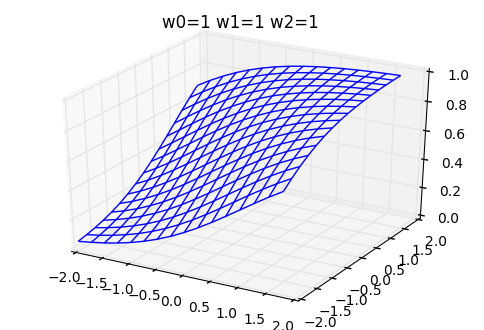

In [17]:
# created on 6th Jun 2017, by Wang Yi 
# logistic REGRESSION
def _sigmoid(z):
    return np.divide(1, 1+np.exp(-z))

def sigmoid(w, X):
    if hasattr(X, "dot"):
        z = X.dot(w)
    elif hasattr(X, "__len__"):
        temp = map(lambda (i, mat): w[i] * mat, enumerate(X))
        z = reduce(lambda pre, curr: pre + curr, temp)
    else:
        z = X*w
    return _sigmoid(z)

def hypo_func(w, X):
    return _sigmoid(X.dot(w))

def hypo_mesh(w, X):
    temp = map(lambda (i, mesh): w[i] * mesh, enumerate(X))
    z = reduce(lambda pre, curr: pre + curr, temp)
    return _sigmoid(z)
    
def plot_hypothesis3D(w, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
    X, Y = np.mgrid[-2:2:0.25, -2:2:0.25]
    X0 = np.ones(X.shape)
    Z = hypo_mesh(w, (X0, X, Y)) # here is a mesh matrix array
    ax.plot_wireframe(X, Y, Z, cstride=1, rstride=1)
    ax.set_title("".join(map(lambda (i, v): "w{id}={val} ".format(id=i, val=v), enumerate(w))))
    # plt.show()
    return ax

plot_hypothesis3D(np.array((1,1,1)))

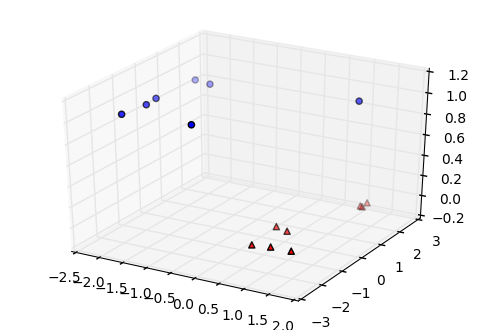

In [19]:
# data copy from internet
# ref http://cpmarkchang.logdown.com/posts/189069-logisti-regression-model

X0=np.array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
              1.,  1.])
X1=np.array([ 0.56,  1.40,  1.38,  1.25, -1.91,
              1.42,  0.97, -1.95, -0.65,  0.84,
              1.37, -1.90, -2.00 ,-1.54,  0.63])

X2=np.array([-0.55,  1.99, -1.78,  1.75, -0.99,
              1.68, -1.79, -0.47, -1.72, -0.69,
              1.71,  1.22, -1.88,  1.11, -1.89])

Z =np.array([-0.20, -0.10, -2.69,  0.02,  4.42,
             -0.36, -1.89,  4.88,  1.40, -0.87,
             -0.25,  5.97,  3.98,  5.15, -1.28])

def plot_data(ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
    ax.scatter(X1[Z>=0], X2[Z>=0], np.ones( X1[Z>=0].shape) ,c='b',marker='o')
    ax.scatter(X1[Z< 0], X2[Z< 0], np.zeros(X1[Z< 0].shape) ,c='r',marker='^')
    # plt.show()
    return ax

plot_data()

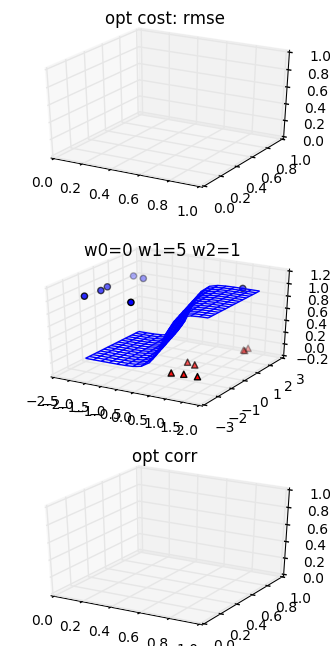

In [21]:
def user_plot(w):
    # plt.style.use('ggplot')
    fig = plt.figure(figsize=plt.figaspect(2.))
    ax_rmse = fig.add_subplot(3, 1, 1, projection='3d')              
    ax_rmse.set_title("opt cost: rmse")
    ax_logloss = fig.add_subplot(3, 1, 2, projection='3d')
    ax_logloss.set_title("opt cost: logloss")
    ax_corr = fig.add_subplot(3, 1, 3, projection='3d')
    ax_corr.set_title("opt corr")
    
    plot_data(ax=ax_logloss)
    plot_hypothesis3D(w, ax=ax_logloss)
    
    plt.show()
    
user_plot(np.array((0, 5, 1)))

In [22]:
EPILON = 1.0e-8

In [23]:
# decoratorLib from PEP 318 standard
def accepts(*types):
    def check_accepts(f):
        assert len(types) == f.func_code.co_argcount
        def new_f(*args, **kwds):
            for (a, t) in zip(args, types):
                assert isinstance(a, t), \
                       "arg %r does not match %s" % (a,t)
            return f(*args, **kwds)
        new_f.func_name = f.func_name
        return new_f
    return check_accepts

def returns(rtype):
    def check_returns(f):
        def new_f(*args, **kwds):
            result = f(*args, **kwds)
            assert isinstance(result, rtype), \
                   "return value %r does not match %s" % (result,rtype)
            return result
        new_f.func_name = f.func_name
        return new_f
    return check_returns

# add cost adaptor for fmin_cg
def cost_adaptor(*args, **kw):
    def wrapper(f):
        def adaptor(theta):
            return f(theta, *args, **kw)
        return adaptor
    return wrapper

In [80]:
# lrCostFunc
# created at 14/12/15, 11:40 AM by WANG YI, lwang019@e.ntu.edu.sg
# updated on 6th Jun, 2017 by WANG YI, lwang11@mtu.edu
#   1. add line search
#   2. support corr supervised learning
# ALL RIGHTS RESERVED

def logloss(p, q):
    return np.sum(cross_entropy(p, q), axis=0) 
    
def cross_entropy(p, q):
    return -p * np.log(q) - (1-p) * np.log(1-q)

def lasso(theta):
    ret = np.abs(theta)
    if hasattr(theta, "__len__"):
        ret[0] = 0
    return ret

# You might also want to use approximate function here
# for more information please refer to Proximal Gradient Methods, the following equation is equivalent to Proximal Gradient Methods
def lasso_prox_grad(theta, epilon=EPILON):
    if hasattr(theta, "__len__"):
        p = len(theta)
        ret = np.array(map(lambda i: np.sign(theta[i]) if theta[i] >= epilon else 0, np.arange(p)))
    ret = np.sign(theta) if theta >= epilon else 0
    return ret

learning_rate = 0.1
@cost_adaptor(np.column_stack([X0, X1, X2]), Z, sigmoid, learning_rate, lasso, None)
def lrCostFunc(theta, X, y, hypo, _lambda, reg_f, reg_g):
    n, p = X.shape
    if reg_g is not None and reg_f is not None:
        reg = reg_f(theta)
        # grad = 1.0/n * (X.T).dot(sigmoid(theta, X) - y)
        grad = np.array(map(lambda i: 1.0/n * X[:,i].dot(sigmoid(theta, X) - y) +  1.0/n * _lambda * reg_g(reg[i], epilon=_lambda), np.arange(p)))
        J = 1.0/n * logloss(y, sigmoid(theta, X)) + _lambda/(2*n) * np.sum(reg)
    else:
        # grad = 1.0/n * (X.T).dot(sigmoid(theta, X) - y)
        grad = np.array(map(lambda i: 1.0/n * X[:,i].dot(sigmoid(theta, X) - y), np.arange(p)))
        J = 1.0/n * logloss(y, sigmoid(theta, X))
        # grad = np.array(map(lambda i: 1.0/n * np.sum(sigmoid(y, X.dot(theta))*y*X[:,i]), np.arange(p)))
        # J = 1.0/n * np.sum(np.log(1 + np.exp(-y * X.dot(theta))))
    return (J, grad)

# derived from max likelyhood
@cost_adaptor(np.column_stack([X0, X1, X2]), Z, sigmoid, learning_rate, lasso, None)
def lrCross_Entropy(theta, X, y, hypo, _lambda, reg_f, reg_g):
    n, p = X.shape
    temp_err = np.divide(1, 1 + np.exp(y * X.dot(theta)))
    g1 = np.average(temp_err * (-y * X[:, 0]))
    g2 = np.average(temp_err * (-y * X[:, 1]))
    g3 = np.average(temp_err * (-y * X[:, 2]))
    J = 1.0/n * np.sum( np.divide(1, 1 + np.exp(y * X.dot(theta))) )
    return (J, np.array((g1, g2, g3)))

# X0 will be replaced by a step func
@cost_adaptor(np.column_stack([X1, X2]), Z, sigmoid, learning_rate, lasso, None)
def corr(theta, X, y, hypo, V, _lambda, reg_f, reg_g):
    pass

def wolf_powell(f, fk, xk, lr, g):
    c1 = 0.01
    c2 = 0.8
    EPILON = 0.01
    p = - g
    alpha = 1.0
    
    maxIter = 4
    i = 0
    flag1 = True
    flag2 = True
    print("begin line search")
    while (flag1 or flag2) and i < maxIter:
        fkplus = f(xk + alpha * p)
        temp1 = fkplus[0] - fk + c1 * alpha * g.dot(p)
        flag1 = temp1 > 0
        temp2 = fkplus[1].dot(p) - c2 * g.dot(p)
        flag2 = temp2 < 0 and np.abs(temp2) < EPILON
        print(" f(xk + alpha*p)  =%6.2f %2s  fk+c1*alpha*g@p=%6.2f" % (fkplus[0], '>' if flag1 else '<=', fk + c1 * alpha * g.dot(p)))
        print("df(xk + alpha*p)*p=%6.2f %2s           c2*g@p=%6.2f" % (fkplus[1].dot(p), '<' if flag2 else '>=', c2 * g.dot(p)))
        alpha = alpha*(1.0 - alpha / 2)
        i += 1
    print("end line search")
    print("step ratio %6.2f" % alpha)
    return alpha

def fmin_cg(cost, init_param, options={}):
    gifseq = options['gifseq']
    maxIter = options['maxIter']
    weights = init_param
    lr = options['learning_rate']
    line_search = options['line_search']
    alpha = int(1)
    user_call = options['user_call']
    hypo = options['hypo']
    i = 0
    J0 = 10
    while i < maxIter:
        J1, grad = cost(weights)
        print("Iteration %s, error %s" % (i, J1))
        print("grad %s" % grad)
        if np.abs(J0 - J1) < EPILON and grad.dot(grad) < EPILON:
            print("convergent! at iteration %s" % i)
            print("with weights %s" % weights)
            print("grad %s" % grad)
            break
        # linear search here
        if line_search:
            alpha = wolf_powell(cost, J1, weights, lr, grad)
            weights = weights - alpha * grad
        else:
            weights = weights - lr * grad
            
        if user_call and i in gifseq:
            user_call(weights)
        J0 = J1
        i += 1
    return weights

def batch(mat, ratio=1.0):
    r, _ = mat.shape
    return randperm(mat)[:int(r*ratio) + 1]

def randperm(mat):
    return np.random.permutation(mat)

def InitalizWeights(*size):
    return np.random.rand(*size)

Iteration 0, error 0.648446943469
grad [-1.46050219  3.05102672  0.25065395]
begin line search
 f(xk + alpha*p)  =  0.21 <=  fk+c1*alpha*g@p=  0.53
df(xk + alpha*p)*p= -0.13 >=           c2*g@p= -9.20
end line search
step ratio   0.50
Iteration 1, error 0.27843386856
grad [-0.01427315  0.20627185  0.15474863]
begin line search
 f(xk + alpha*p)  =  0.26 <=  fk+c1*alpha*g@p=  0.28
df(xk + alpha*p)*p= -0.03 >=           c2*g@p= -0.05
end line search
step ratio   0.50
Iteration 2, error 0.263939884917
grad [ 0.02462814  0.13961681  0.08052955]
begin line search
 f(xk + alpha*p)  =  0.25 <=  fk+c1*alpha*g@p=  0.26
df(xk + alpha*p)*p= -0.02 >=           c2*g@p= -0.02
end line search
step ratio   0.50


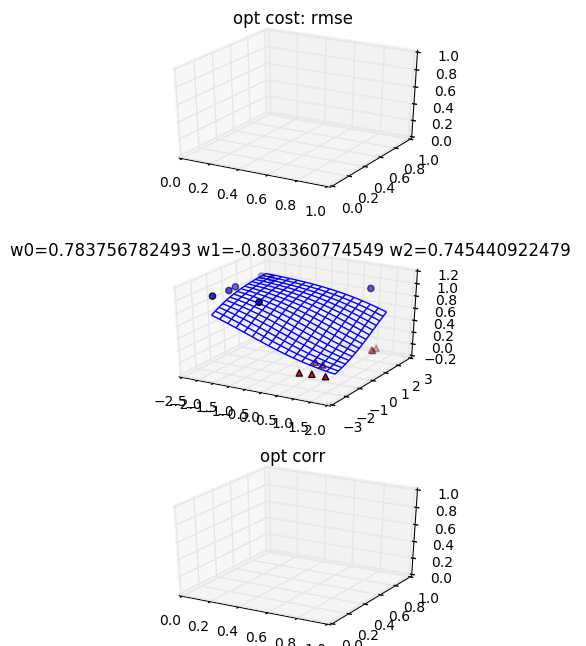

Iteration 3, error 0.257343983057
grad [ 0.03316495  0.1232708   0.06248862]
begin line search
 f(xk + alpha*p)  =  0.25 <=  fk+c1*alpha*g@p=  0.26
df(xk + alpha*p)*p= -0.02  <           c2*g@p= -0.02
 f(xk + alpha*p)  =  0.25 <=  fk+c1*alpha*g@p=  0.26
df(xk + alpha*p)*p= -0.02  <           c2*g@p= -0.02
 f(xk + alpha*p)  =  0.25 <=  fk+c1*alpha*g@p=  0.26
df(xk + alpha*p)*p= -0.02  <           c2*g@p= -0.02
 f(xk + alpha*p)  =  0.25 <=  fk+c1*alpha*g@p=  0.26
df(xk + alpha*p)*p= -0.02  <           c2*g@p= -0.02
end line search
step ratio   0.26
Iteration 4, error 0.254604293007
grad [ 0.03514385  0.11843755  0.05769263]
begin line search
 f(xk + alpha*p)  =  0.25 <=  fk+c1*alpha*g@p=  0.25
df(xk + alpha*p)*p= -0.02  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.25 <=  fk+c1*alpha*g@p=  0.25
df(xk + alpha*p)*p= -0.02  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.25 <=  fk+c1*alpha*g@p=  0.25
df(xk + alpha*p)*p= -0.02  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.25 <=  fk+c

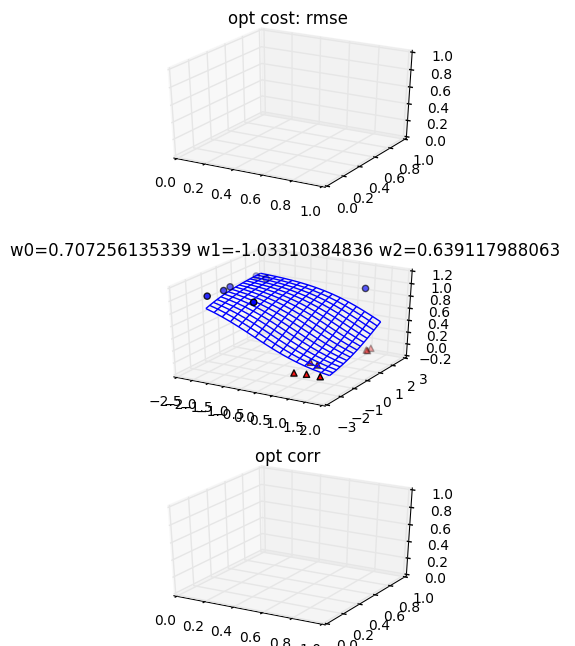

Iteration 11, error 0.238946570358
grad [ 0.03897322  0.10051044  0.0430071 ]
begin line search
 f(xk + alpha*p)  =  0.23 <=  fk+c1*alpha*g@p=  0.24
df(xk + alpha*p)*p= -0.01  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.24 <=  fk+c1*alpha*g@p=  0.24
df(xk + alpha*p)*p= -0.01  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.24 <=  fk+c1*alpha*g@p=  0.24
df(xk + alpha*p)*p= -0.01  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.24 <=  fk+c1*alpha*g@p=  0.24
df(xk + alpha*p)*p= -0.01  <           c2*g@p= -0.01
end line search
step ratio   0.26
Iteration 12, error 0.236982088312
grad [ 0.03900668  0.09881696  0.04190987]
begin line search
 f(xk + alpha*p)  =  0.23 <=  fk+c1*alpha*g@p=  0.24
df(xk + alpha*p)*p= -0.01  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.23 <=  fk+c1*alpha*g@p=  0.24
df(xk + alpha*p)*p= -0.01  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.23 <=  fk+c1*alpha*g@p=  0.24
df(xk + alpha*p)*p= -0.01  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.23 <=  fk

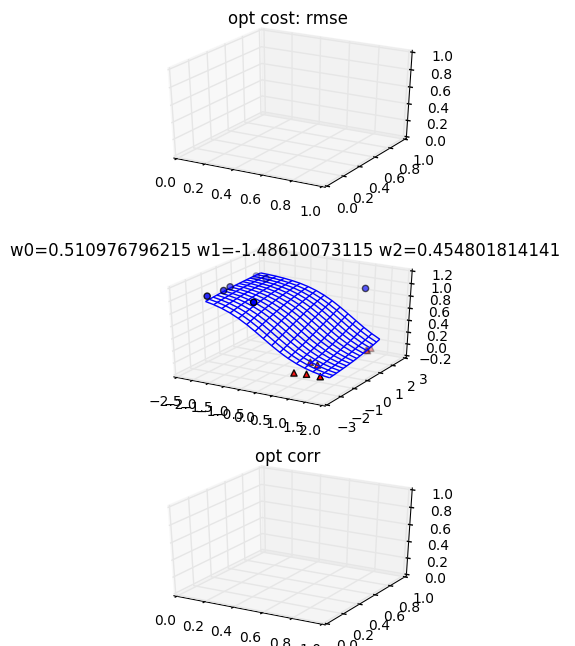

Iteration 31, error 0.206414095018
grad [ 0.0362071   0.07614829  0.02975071]
begin line search
 f(xk + alpha*p)  =  0.20 <=  fk+c1*alpha*g@p=  0.21
df(xk + alpha*p)*p= -0.01  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.20 <=  fk+c1*alpha*g@p=  0.21
df(xk + alpha*p)*p= -0.01  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.20 <=  fk+c1*alpha*g@p=  0.21
df(xk + alpha*p)*p= -0.01  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.20 <=  fk+c1*alpha*g@p=  0.21
df(xk + alpha*p)*p= -0.01  <           c2*g@p= -0.01
end line search
step ratio   0.26
Iteration 32, error 0.205087355694
grad [ 0.0360071   0.07524073  0.02932397]
begin line search
 f(xk + alpha*p)  =  0.20 <=  fk+c1*alpha*g@p=  0.21
df(xk + alpha*p)*p= -0.01  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.20 <=  fk+c1*alpha*g@p=  0.21
df(xk + alpha*p)*p= -0.01  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.20 <=  fk+c1*alpha*g@p=  0.21
df(xk + alpha*p)*p= -0.01  <           c2*g@p= -0.01
 f(xk + alpha*p)  =  0.20 <=  fk

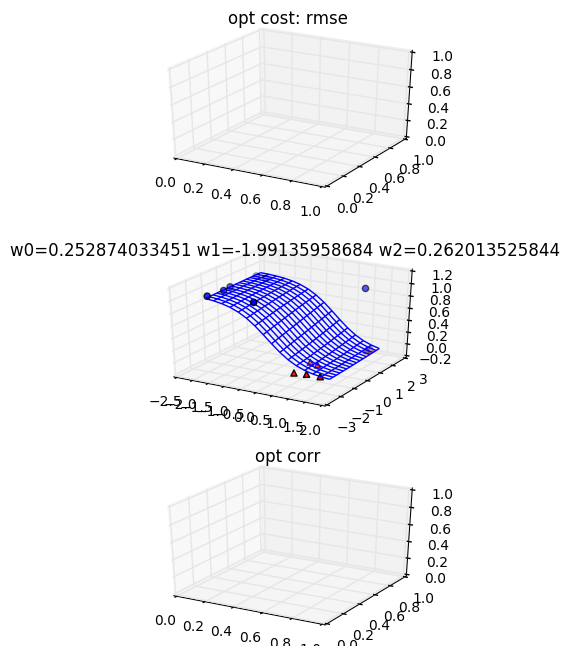

Iteration 61, error 0.174877646079
grad [ 0.03033683  0.05559474  0.02082582]
begin line search
 f(xk + alpha*p)  =  0.17 <=  fk+c1*alpha*g@p=  0.17
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.17 <=  fk+c1*alpha*g@p=  0.17
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.17 <=  fk+c1*alpha*g@p=  0.17
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.17 <=  fk+c1*alpha*g@p=  0.17
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
end line search
step ratio   0.26
Iteration 62, error 0.174061795187
grad [ 0.03015816  0.05508972  0.02062335]
begin line search
 f(xk + alpha*p)  =  0.17 <=  fk+c1*alpha*g@p=  0.17
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.17 <=  fk+c1*alpha*g@p=  0.17
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.17 <=  fk+c1*alpha*g@p=  0.17
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.17 <=  fk

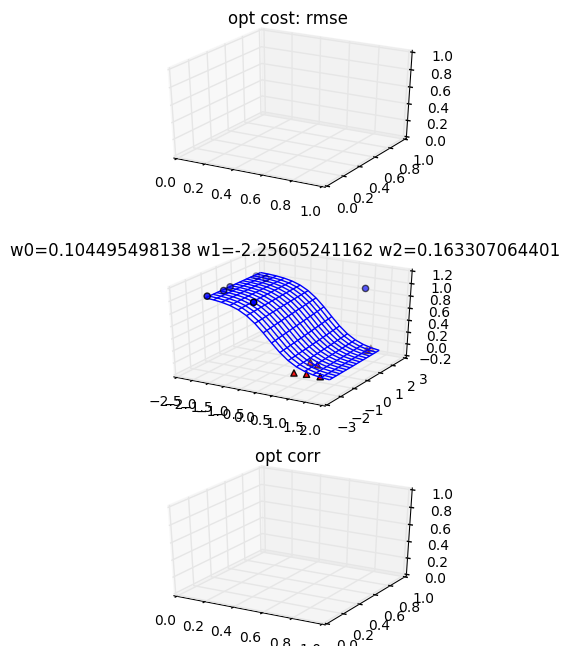

Iteration 81, error 0.160566744345
grad [ 0.0270498   0.04692538  0.01743328]
begin line search
 f(xk + alpha*p)  =  0.16 <=  fk+c1*alpha*g@p=  0.16
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.16 <=  fk+c1*alpha*g@p=  0.16
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.16 <=  fk+c1*alpha*g@p=  0.16
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.16 <=  fk+c1*alpha*g@p=  0.16
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
end line search
step ratio   0.26
Iteration 82, error 0.159948294938
grad [ 0.02690107  0.04655979  0.01729366]
begin line search
 f(xk + alpha*p)  =  0.16 <=  fk+c1*alpha*g@p=  0.16
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.16 <=  fk+c1*alpha*g@p=  0.16
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.16 <=  fk+c1*alpha*g@p=  0.16
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.16 <=  fk

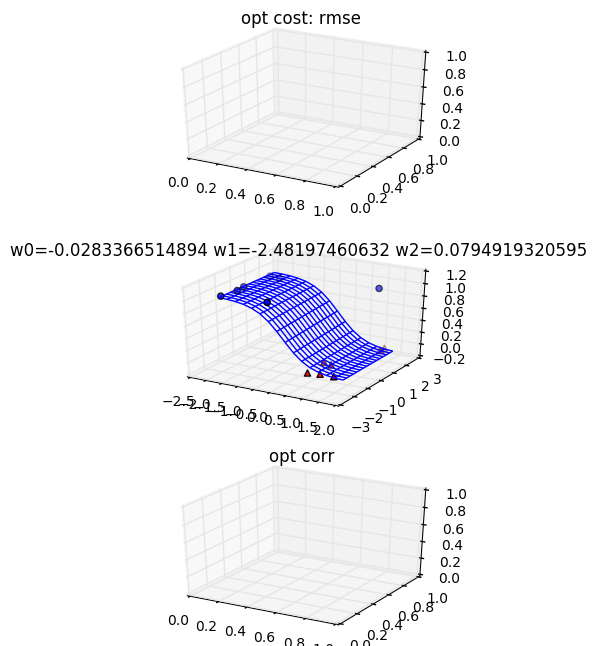

Iteration 101, error 0.14955987934
grad [ 0.02433398  0.04053232  0.01502302]
begin line search
 f(xk + alpha*p)  =  0.15 <=  fk+c1*alpha*g@p=  0.15
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.15 <=  fk+c1*alpha*g@p=  0.15
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.15 <=  fk+c1*alpha*g@p=  0.15
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.15 <=  fk+c1*alpha*g@p=  0.15
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
end line search
step ratio   0.26
Iteration 102, error 0.14907630037
grad [ 0.02421161  0.04025702  0.01492053]
begin line search
 f(xk + alpha*p)  =  0.15 <=  fk+c1*alpha*g@p=  0.15
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.15 <=  fk+c1*alpha*g@p=  0.15
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.15 <=  fk+c1*alpha*g@p=  0.15
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.15 <=  fk

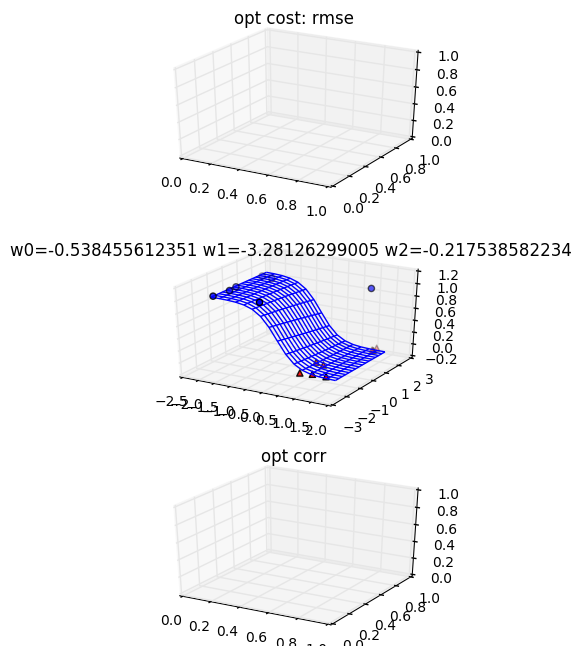

Iteration 201, error 0.118824650361
grad [ 0.0162351   0.02405119  0.00898268]
begin line search
 f(xk + alpha*p)  =  0.12 <=  fk+c1*alpha*g@p=  0.12
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.12 <=  fk+c1*alpha*g@p=  0.12
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.12 <=  fk+c1*alpha*g@p=  0.12
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.12 <=  fk+c1*alpha*g@p=  0.12
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
end line search
step ratio   0.26
Iteration 202, error 0.118630656056
grad [ 0.01618286  0.02395438  0.00894735]
begin line search
 f(xk + alpha*p)  =  0.12 <=  fk+c1*alpha*g@p=  0.12
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.12 <=  fk+c1*alpha*g@p=  0.12
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.12 <=  fk+c1*alpha*g@p=  0.12
df(xk + alpha*p)*p= -0.00  <           c2*g@p= -0.00
 f(xk + alpha*p)  =  0.12 <=  

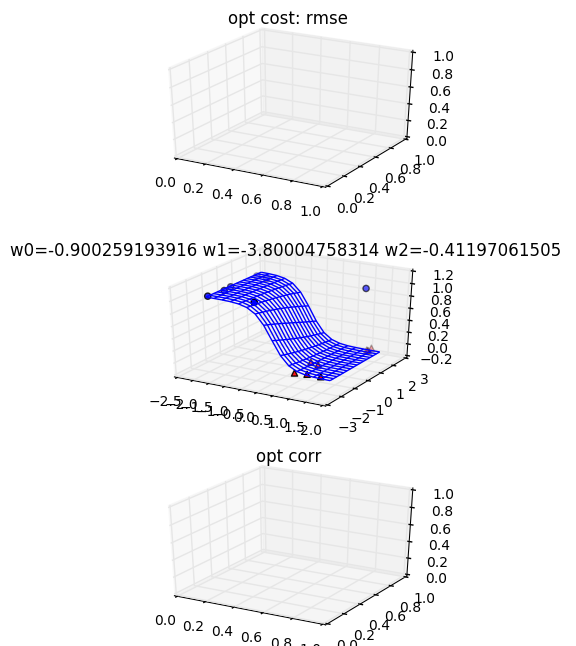

array([-0.90025919, -3.80004758, -0.41197062])

In [81]:
option = {
    'maxIter': 300,
    'learning_rate': 1,
    'watch': None,
    'user_call': user_plot,
    'line_search': True,
    'hypo': logistic_hypo,
    'gifseq': [2, 10, 30, 60, 80, 100, 200, 299, 300, 1000]
}

theta = InitalizWeights(3)
fmin_cg(lrCross_Entropy, init_param=theta, options=option)

In [95]:
# step func test
def map_decl(f):
    tbl = {}
    def wrap(idx):
        if tbl.get(idx, None) is not None:
            print("idx: %d" % idx)
            return tbl[idx]
        return f(idx)
    return wrap

@map_decl
def alpha(i):
    if i == 0:
        return 1.0
    return alpha(i-1) * (1 - alpha(i-1) / 2)

for i in range(20):
    print("%6.3f" % alpha(i))

 1.000
 0.500
 0.375
 0.305
 0.258
 0.225
 0.200
 0.180
 0.164
 0.150
 0.139
 0.129
 0.121
 0.114
 0.107
 0.101
 0.096
 0.092
 0.087
 0.084
